Монтируем google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

drive = 1
if drive==1:
  prefix = '/content/drive/My Drive/Studying/Netology/Diploma'
else:
  prefix = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Устанавливаем зависимости

In [2]:
import sys, os
sys.path.append(os.path.join(prefix,'lib'))

In [3]:
from service_lib import install_dependences
install_dependences()

All dependences are installed!


Импортируем необходимые библиотеки

In [4]:
import torch, torchvision
import os
import cv2
print(torch.__version__, torch.cuda.is_available(), torchvision.__version__)

from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from config_lib import make_config_detector, make_config_symbols
from visual_lib import visualize_with_rect, visualize

import glob
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

%matplotlib inline

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



1.7.0+cu101 True 0.8.1+cu101


In [5]:
cfg = make_config_detector(get_cfg(), prefix)

In [38]:
carplate_predictor = DefaultPredictor(cfg)

In [7]:
test_photos = glob.glob(os.path.join(prefix,'data', 'test','*.*'))

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


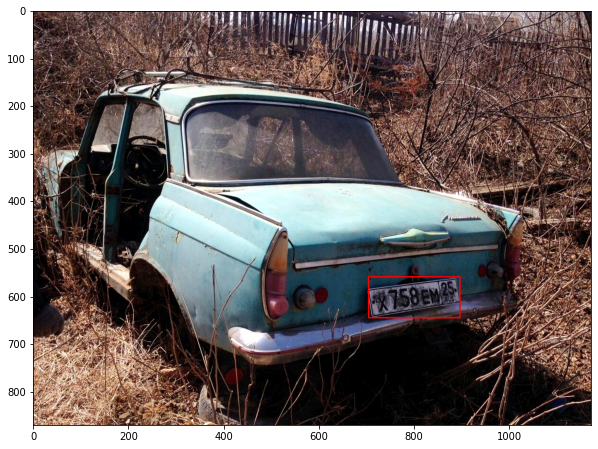

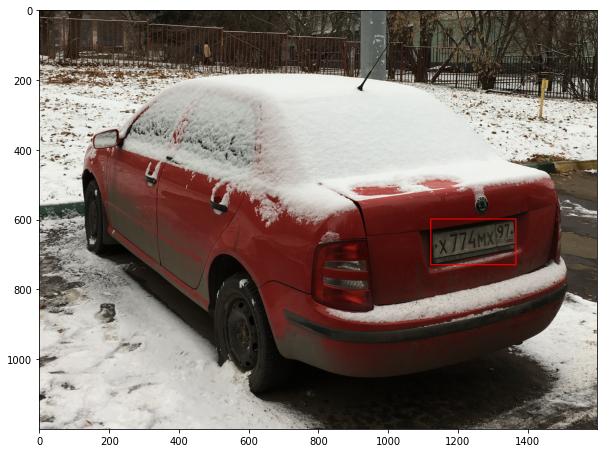

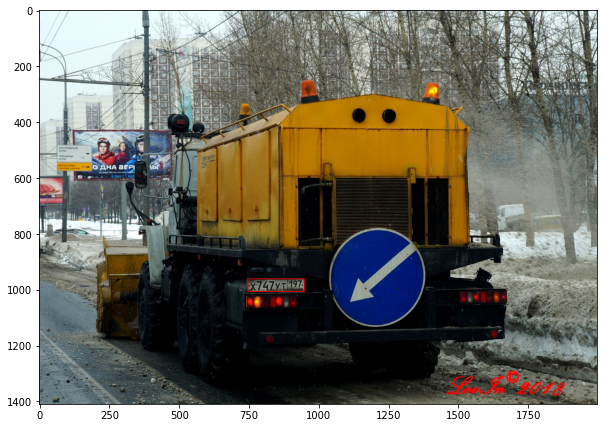

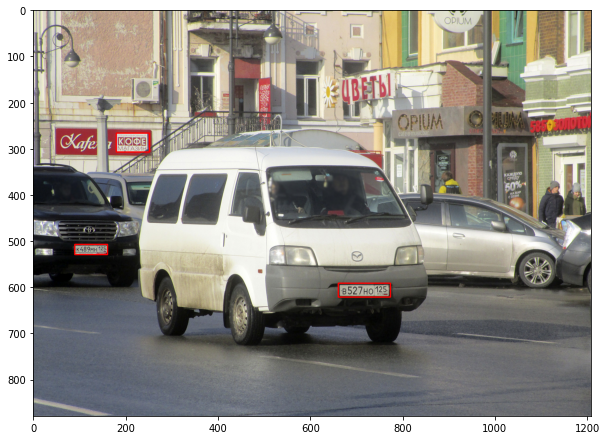

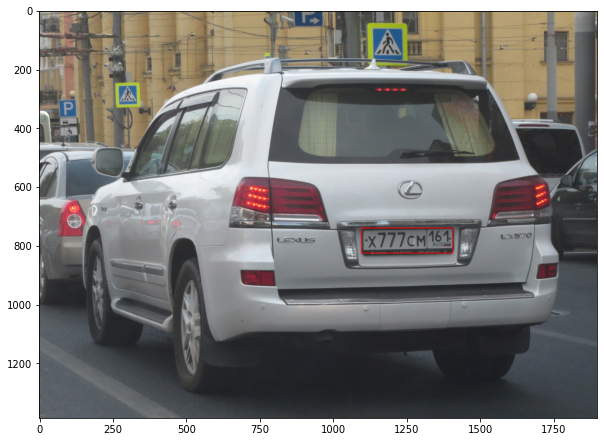

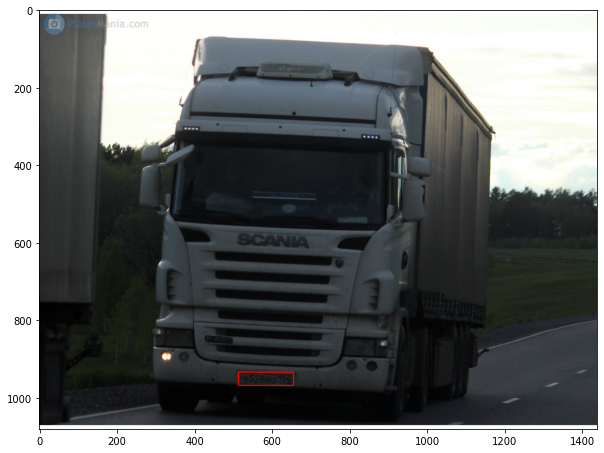

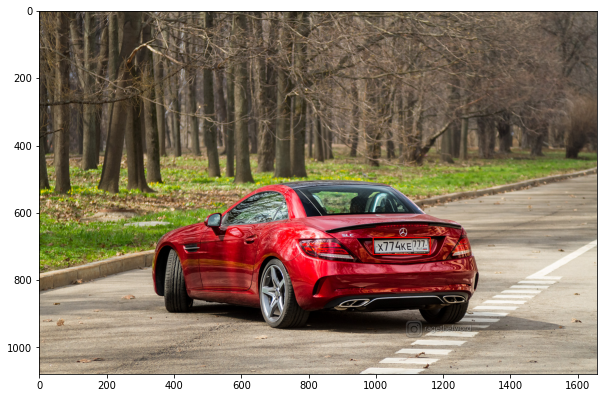

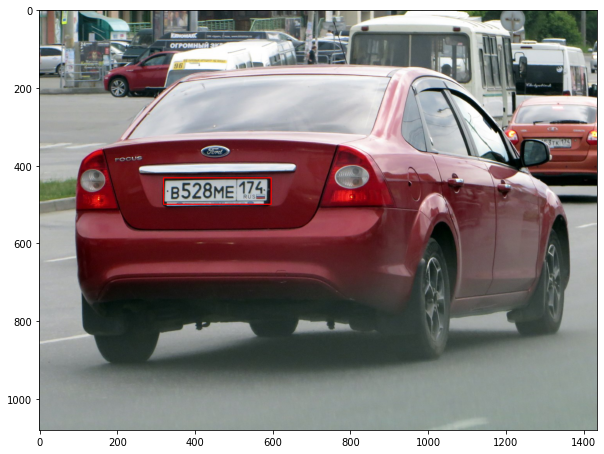

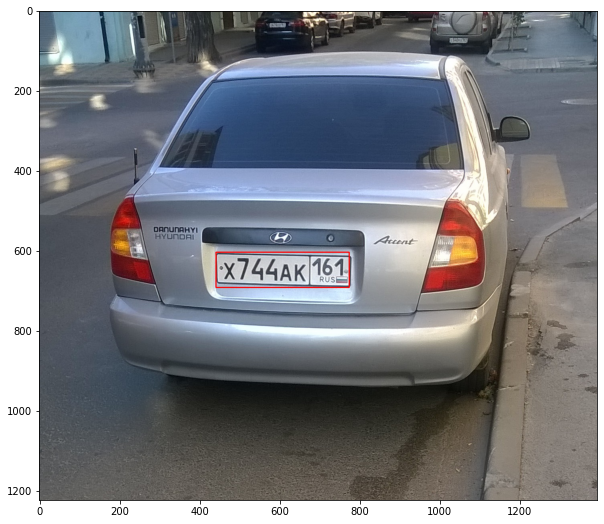

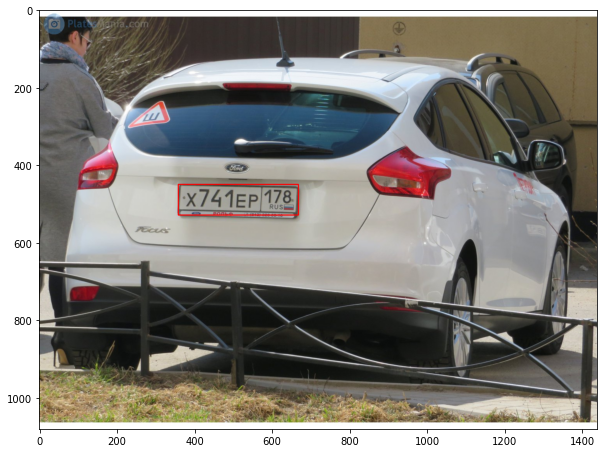

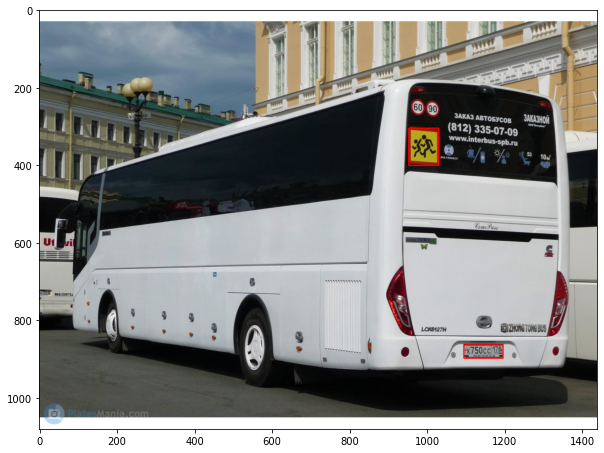

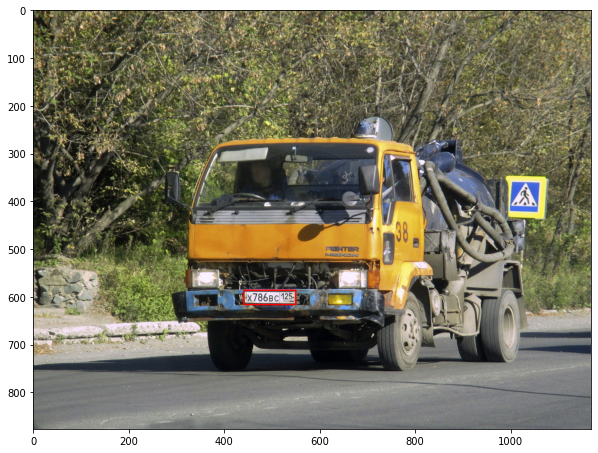

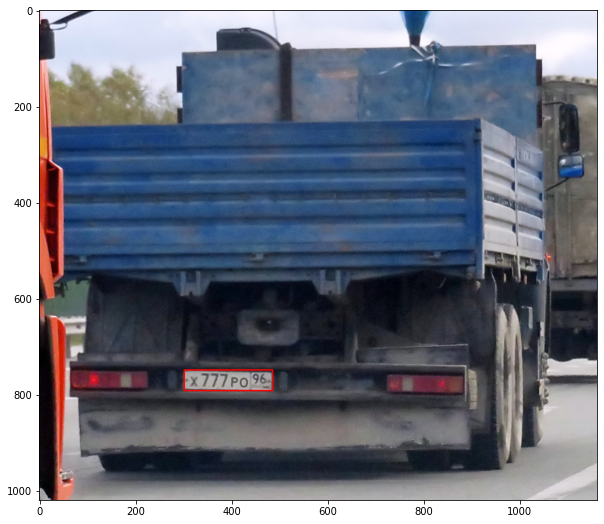

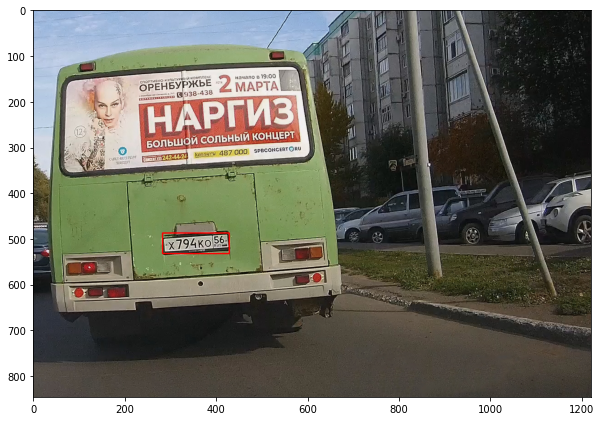

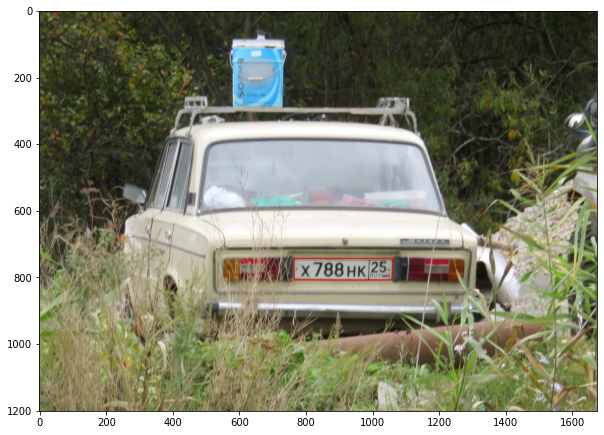

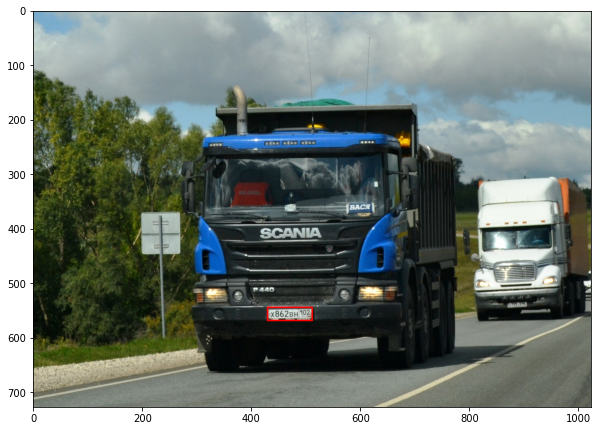

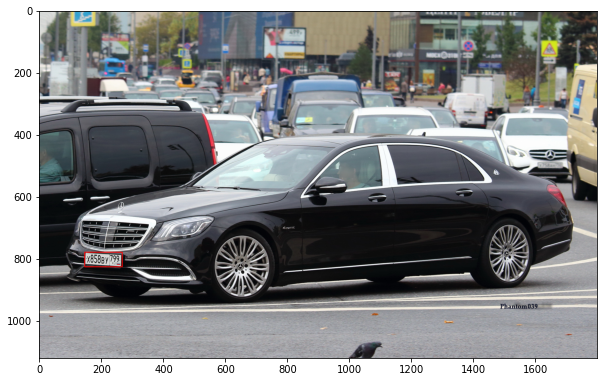

In [8]:
im_list = []
for image in test_photos:
  im = cv2.imread(image, cv2.IMREAD_UNCHANGED)
  out = predictor(im)
  im_list.append((im, out['instances'].get('pred_boxes')))
  visualize_with_rect(im, out['instances'].get('pred_boxes'))

In [58]:
class ImagePrediction(object):
    def __init__(self, img_path, predictor):
      self.path = img_path
      self.predictor = predictor
      self.img = cv2.imread(self.path, cv2.IMREAD_UNCHANGED)
      self.prediction = predictor(self.img)
      self.pred_boxes = self.prediction['instances'].get('pred_boxes')
      self.pred_scores = self.prediction['instances'].get('scores')

      self.cropped_plates = self.crop_carplates()

      self.tesseract_res = self.get_tesseract_results()
      self.custom_res = self.get_custom_result()

    def crop_carplates(self):
      output = []
      for r in self.pred_boxes:
        y_min = math.floor(r[0])
        y_max = math.ceil(r[2])
        x_min = math.floor(r[1])
        x_max = math.ceil(r[3])
        plate = image[x_min:x_max, y_min:y_max, :]
        output.append(plate)
      return output

    def get_tesseract_results(self):
      result = []
      for p in self.cropped_plates:
        tes_img = self.prepare_img_for_tesseract(p)
        result.append(pytesseract.image_to_string(tes_img, 
                                                  config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=ABCEHKMOPTXY0123456789'))
      return result

    def get_custom_result(self):
      cfg_sym = get_cfg()
      cfg_sym = make_config_symbols(cfg_sym, prefix)

      result = []
      predictor_symbols = DefaultPredictor(cfg_sym)
      for p in self.cropped_plates:
        out = predictor_symbols(p)
        result.append(make_string_from_pred_1(out))
      return result
      

    
    def make_string_from_pred_1(outputs):
      dict_ = {'0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6', '7':'7', '8':'8', '9':'9', 
                    '10':'A', '11':'B', '12':'C', '13':'E', '14':'H', '15':'K', '16':'M', '17':'O',
                    '18':'P', '19':'T', '20':'X', '21':'Y'}
      pred_boxes = outputs["instances"].get('pred_boxes').get_centers().to("cpu")
      pred_scores = outputs["instances"].get('scores').to("cpu")
      pred_classes = outputs["instances"].get('pred_classes').to("cpu")
      d = {}
      s = {}
      for i in range(len(pred_classes)):
        d[i] = float(pred_boxes[i][0])
        s[i] = float(pred_scores[i])
      sorted_list = [(i,d[i],s[i]) for i in sorted(d, key=d.get)]

      l=[sorted_list[0]]
      for i in range(len(sorted_list)):
        if ((sorted_list[i][1]-l[-1][1]) < 5):
          if ((sorted_list[i][2]-l[-1][2]) <= 0):
            continue
          else:
            l[-1] = sorted_list[i]
        else:
          l.append(sorted_list[i])

      str_ = ''
      for i in [i[0] for i in l]:
        str_ += dict_[str(int(pred_classes[i]))] 

      return str_




    def enlarge_img(self, image, scale_percent):
      width = int(image.shape[1] * scale_percent / 100)
      height = int(image.shape[0] * scale_percent / 100)
      dim = (width, height)
      resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)    
      return resized_image 

    def prepare_img_for_tesseract(self, img):
      img = self.enlarge_img(img, 150)
      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      return gray



In [59]:
print(ImagePrediction(test_photos[4], predictor=carplate_predictor).tesseract_res)
print(ImagePrediction(test_photos[4], predictor=carplate_predictor).custom_res)


['x77 7¢M et\n\x0c']
['X777CM16']


In [10]:
image, rects = im_list[4]

In [11]:
def crop_carplates(image, rects):
  output = []
  for r in rects:
    y_min = math.floor(r[0])
    y_max = math.ceil(r[2])
    x_min = math.floor(r[1])
    x_max = math.ceil(r[3])
    plate = image[x_min:x_max, y_min:y_max, :]
    output.append(plate)
  return output

In [12]:
plates = crop_carplates(image, rects)

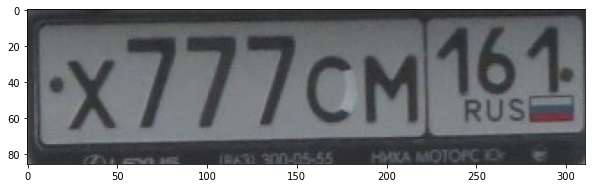

In [13]:
for p in plates:
  visualize(p)

In [14]:
# Enlarge image for further processing later on
def enlarge_img(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)    
    return resized_image

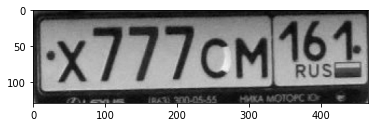

In [15]:
carplate_extract_img = plates[0]
def make_img_greyscale(img):
  img = enlarge_img(img, 150)
  # Convert image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return gray
carplate_extract_img_gray = make_img_greyscale(carplate_extract_img)
plt.imshow(carplate_extract_img_gray, cmap = 'gray');

In [16]:
# Display the text extracted from the car plate
print(pytesseract.image_to_string(carplate_extract_img_gray, 
                                  config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=ABCEHKMOPTXY0123456789'))

x77 7¢M et



**RECOGNIZOR_2**

In [56]:
# register_coco_instances("plates_train", {}, 
#                         os.path.join(prefix, 'data', 'coco_syn_plates_train_annotations.json'),
#                         os.path.join(prefix, 'data', 'synthetic_plates_train'))
# plates_train_metadata = MetadataCatalog.get("plates_train")

In [18]:
cfg_sym = get_cfg()
cfg_sym = make_config_symbols(cfg_sym, prefix)

In [19]:
predictor = DefaultPredictor(cfg_sym)

In [34]:
import random
import pandas as pd
import numpy as np
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

%matplotlib inline

def visualize(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 50))
    plt.imshow(image)

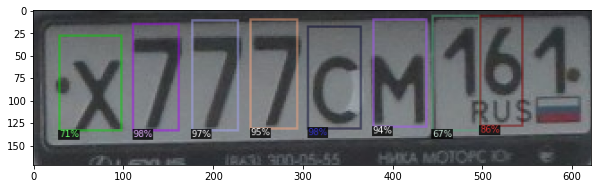

In [35]:
img = carplate_extract_img
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1],
                   metadata=plates_train_metadata, 
                   scale=2
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
visualize(out.get_image()[:, :, ::-1])

In [22]:
def make_string_from_pred(outputs):
  dict_ = {'0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6', '7':'7', '8':'8', '9':'9', 
                '10':'A', '11':'B', '12':'C', '13':'E', '14':'H', '15':'K', '16':'M', '17':'O',
                '18':'P', '19':'T', '20':'X', '21':'Y'}
  pred_boxes = outputs["instances"].get('pred_boxes').get_centers().to("cpu")
  scores = outputs["instances"].get('scores').to("cpu")
  pred_classes = outputs["instances"].get('pred_classes').to("cpu")
  d = {}
  for i in range(len(pred_classes)):
    d[i] = float(pred_boxes[i][0])
  str_ = ''
  for i in sorted(d, key=d.get):
    str_ += dict_[str(int(pred_classes[i]))] 

  return str_

In [25]:
def make_string_from_pred_1(outputs):
  dict_ = {'0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6', '7':'7', '8':'8', '9':'9', 
                '10':'A', '11':'B', '12':'C', '13':'E', '14':'H', '15':'K', '16':'M', '17':'O',
                '18':'P', '19':'T', '20':'X', '21':'Y'}
  pred_boxes = outputs["instances"].get('pred_boxes').get_centers().to("cpu")
  pred_scores = outputs["instances"].get('scores').to("cpu")
  pred_classes = outputs["instances"].get('pred_classes').to("cpu")
  d = {}
  s = {}
  for i in range(len(pred_classes)):
    d[i] = float(pred_boxes[i][0])
    s[i] = float(pred_scores[i])
  sorted_list = [(i,d[i],s[i]) for i in sorted(d, key=d.get)]

  l=[sorted_list[0]]
  for i in range(len(sorted_list)):
    if ((sorted_list[i][1]-l[-1][1]) < 5):
      if ((sorted_list[i][2]-l[-1][2]) <= 0):
        continue
      else:
        l[-1] = sorted_list[i]
    else:
      l.append(sorted_list[i])

  str_ = ''
  for i in [i[0] for i in l]:
    str_ += dict_[str(int(pred_classes[i]))] 

  return str_

In [26]:
make_string_from_pred_1(outputs)

'X777CM16'

**Recognizor_3**

In [27]:
img = carplate_extract_img

In [28]:
# boxes = [i for i in outputs["instances"].get('pred_boxes').to("cpu")]
rects = outputs["instances"].get('pred_boxes').to("cpu")
pred_classes = outputs["instances"].get('pred_classes').to("cpu")
pred_boxes = outputs["instances"].get('pred_boxes').get_centers().to("cpu")
pred_scores = outputs["instances"].get('scores').to("cpu")

In [30]:
def crop_symbols(img, boxes, pred_classes,pred_scores):
  d = {}
  s = {}
  for i in range(len(pred_classes)):
    d[i] = float(boxes.get_centers()[i][0])
    s[i] = float(pred_scores[i])
  sorted_list = [(i,d[i],s[i]) for i in sorted(d, key=d.get)]
  print(sorted_list)

  l=[sorted_list[0]]
  for i in range(len(sorted_list)):
    if ((sorted_list[i][1]-l[-1][1]) < 5):
      if ((sorted_list[i][2]-l[-1][2]) <= 0):
        continue
      else:
        l[-1] = sorted_list[i]
    else:
      l.append(sorted_list[i])

  print(l)

  symbols_imgs = []
  for r in boxes:
    print(r)
    y_min = math.floor(r[0])
    y_max = math.ceil(r[2])
    x_min = math.floor(r[1])
    x_max = math.ceil(r[3])
    symbols_imgs.append(img[x_min:x_max, y_min:y_max, :])
    symbols_imgs_sorted = []
  last = 0
  for i in [i[0] for i in l]:
    symbols_imgs_sorted.append(symbols_imgs[i])
  
  return symbols_imgs_sorted

In [31]:
cropped_symbols = crop_symbols(img, rects, pred_classes,pred_scores)
len(cropped_symbols)

[(6, 31.84840202331543, 0.7115454077720642), (1, 68.47056579589844, 0.9802271127700806), (2, 101.19666290283203, 0.972553551197052), (3, 134.21945190429688, 0.9548813700675964), (0, 167.88461303710938, 0.9849772453308105), (4, 204.24241638183594, 0.940822422504425), (7, 235.4092254638672, 0.6749839186668396), (5, 260.66632080078125, 0.861111044883728)]
[(6, 31.84840202331543, 0.7115454077720642), (1, 68.47056579589844, 0.9802271127700806), (2, 101.19666290283203, 0.972553551197052), (3, 134.21945190429688, 0.9548813700675964), (0, 167.88461303710938, 0.9849772453308105), (4, 204.24241638183594, 0.940822422504425), (7, 235.4092254638672, 0.6749839186668396), (5, 260.66632080078125, 0.861111044883728)]
tensor([153.1391,   8.8135, 182.6301,  65.5397])
tensor([55.7409,  7.5898, 81.2002, 66.5023])
tensor([ 88.3077,   5.4699, 114.0856,  66.3391])
tensor([121.2224,   4.8034, 147.2164,  65.6529])
tensor([189.2997,   5.0207, 219.1852,  64.6366])
tensor([249.0354,   2.9686, 272.2972,  64.1148])


8

In [32]:
def recognize_symbol(sym, sym_dict):
  sym_gray = make_img_greyscale(sym)
  sym_str = pytesseract.image_to_string(sym_gray, 
                                        config = '--psm 8 --oem 3 -c tessedit_char_whitelist={}'.format(sym_dict))
  return sym_str

In [33]:
number_string = ''
for i, s in enumerate(cropped_symbols):
  if i in [1,2,3,6,7,8]:
    symbol = recognize_symbol(s, '0123456789')[0]
  elif i in [0,4,5]:
    symbol = recognize_symbol(s, 'ABCEHKMOPTXY')[0]
  number_string += symbol
print(number_string)

Y777CM46
